[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20:49:12 - cmdstanpy - INFO - Chain [1] start processing
20:49:13 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found input variables with inconsistent numbers of samples: [124, 80]

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
20:58:52 - cmdstanpy - INFO - Chain [1] start processing
20:58:57 - cmdstanpy - INFO - Chain [1] done processing


MAE: 6714.96162335099
MSE: 70350149.42070079
RMSE: 8387.499592888264


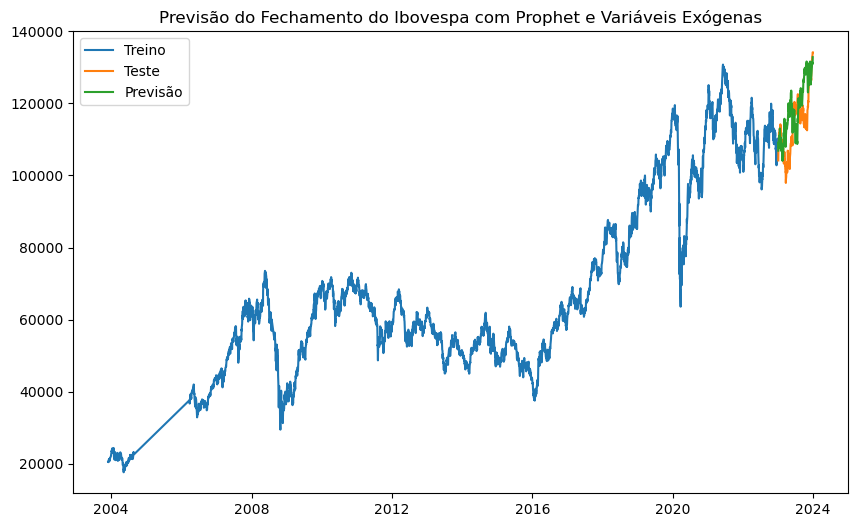

In [6]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Função para calcular o RSI
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Baixar dados do Ibovespa e outras variáveis
ibov = yf.download('^BVSP', start='2001-01-01', end='2024-07-08')['Close']
sp500 = yf.download('^GSPC', start='2001-01-01', end='2024-07-08')['Close']  # S&P 500
usd_brl = yf.download('BRL=X', start='2001-01-01', end='2024-07-08')['Close']  # Taxa de câmbio USD/BRL
oil = yf.download('CL=F', start='2001-01-01', end='2024-07-08')['Close']  # Preço do petróleo

# Criar um DataFrame com o índice de datas comuns
dates = ibov.index

# Reindexar todas as séries para ter as mesmas datas
sp500 = sp500.reindex(dates)
usd_brl = usd_brl.reindex(dates)
oil = oil.reindex(dates)

# Calcular o RSI para o Ibovespa
rsi_ibov = calculate_rsi(ibov, 14).reindex(dates)

# Combinar dados em um único DataFrame
data = pd.DataFrame({
    'ds': dates,
    'y': ibov.values,
    'SP500': sp500.values,
    'USD/BRL': usd_brl.values,
    'Oil': oil.values,
    'RSI_Ibov': rsi_ibov.values
})

# Remover valores nulos
data = data.dropna()

# Dividir dados em treino e teste
train = data[data['ds'] <= '2022-12-31']
test = data[data['ds'] > '2022-12-31']

# Ajustar o modelo Prophet com variáveis exógenas
model = Prophet()
model.add_regressor('SP500')
model.add_regressor('USD/BRL')
model.add_regressor('Oil')
model.add_regressor('RSI_Ibov')

# Treinar o modelo
model.fit(train)

# Fazer previsões
future = model.make_future_dataframe(periods=len(test))
future['SP500'] = data['SP500'].reset_index(drop=True)
future['USD/BRL'] = data['USD/BRL'].reset_index(drop=True)
future['Oil'] = data['Oil'].reset_index(drop=True)
future['RSI_Ibov'] = data['RSI_Ibov'].reset_index(drop=True)
forecast = model.predict(future)

# Alinhar as previsões com o período de teste, garantindo datas comuns
forecast_test = forecast[forecast['ds'].isin(test['ds'])].set_index('ds')
test = test.set_index('ds')
common_dates = test.index.intersection(forecast_test.index)
aligned_forecast = forecast_test.loc[common_dates]
aligned_test = test.loc[common_dates]

# Calcular métricas de acurácia
mae = mean_absolute_error(aligned_test['y'], aligned_forecast['yhat'])
mse = mean_squared_error(aligned_test['y'], aligned_forecast['yhat'])
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Treino')
plt.plot(aligned_test.index, aligned_test['y'], label='Teste')
plt.plot(aligned_forecast.index, aligned_forecast['yhat'], label='Previsão')
plt.legend()
plt.title('Previsão do Fechamento do Ibovespa com Prophet e Variáveis Exógenas')
plt.show()
